# Introduction


### Accessing the Data

In [1]:
# Includuing all additional imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
import pandas as pd
import seaborn as sns
import numpy as np

train = pd.read_csv("https://raw.githubusercontent.com/PhilChodrow/ml-notes/main/data/credit-risk/train.csv")
train.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,25,43200,RENT,NaN,VENTURE,B,1200,9.91,0,0.03,N,4
1,27,98000,RENT,3.0,EDUCATION,C,11750,13.47,0,0.12,Y,6
2,22,36996,RENT,5.0,EDUCATION,A,10000,7.51,0,0.27,N,4
3,24,26000,RENT,2.0,MEDICAL,C,1325,12.87,1,0.05,N,4
4,29,53004,MORTGAGE,2.0,HOMEIMPROVEMENT,A,15000,9.63,0,0.28,N,10


*Including all additional imports*

## Exploring the Data
### Preliminary Visualizations


In [251]:
# Data modification
train_viz = train.copy()
loan_status_recode = {0: 'Paid in Full', 1: 'Defaulted'}
train_viz['Loan Repayment'] = train_viz['loan_status'].map(loan_status_recode)
train_viz = train_viz.dropna()

# Subsetting data by loan status
default = train_viz[train_viz['loan_status'] == 1].copy().dropna()
repaid = train_viz[train_viz['loan_status'] == 0].copy().dropna()

*Modifying training data for visualization*

In [252]:
# Creating linear regression models and calculating R^2 values
## Default
c1 = np.polyfit(default['loan_amnt'], default['person_income'], 1)
p1 = np.polyval(c1, default['loan_amnt'])
r1 = default['person_income'] - p1
ssr1 = np.sum(r1**2)
sst1 = np.sum((default['person_income'] - np.mean(default['loan_amnt']))**2)
rs1 = 1 - (ssr1 / sst1)

## Repaid
c2 = np.polyfit(repaid['loan_amnt'], repaid['person_income'], 1)
p2 = np.polyval(c2, repaid['loan_amnt'])
r2 = repaid['person_income'] - p2
ssr2 = np.sum(r2**2)
sst2 = np.sum((repaid['person_income'] - np.mean(repaid['loan_amnt']))**2)
rs2 = 1 - (ssr2 / sst2)

Text(0.475, 0.05, 'Loan Amount')

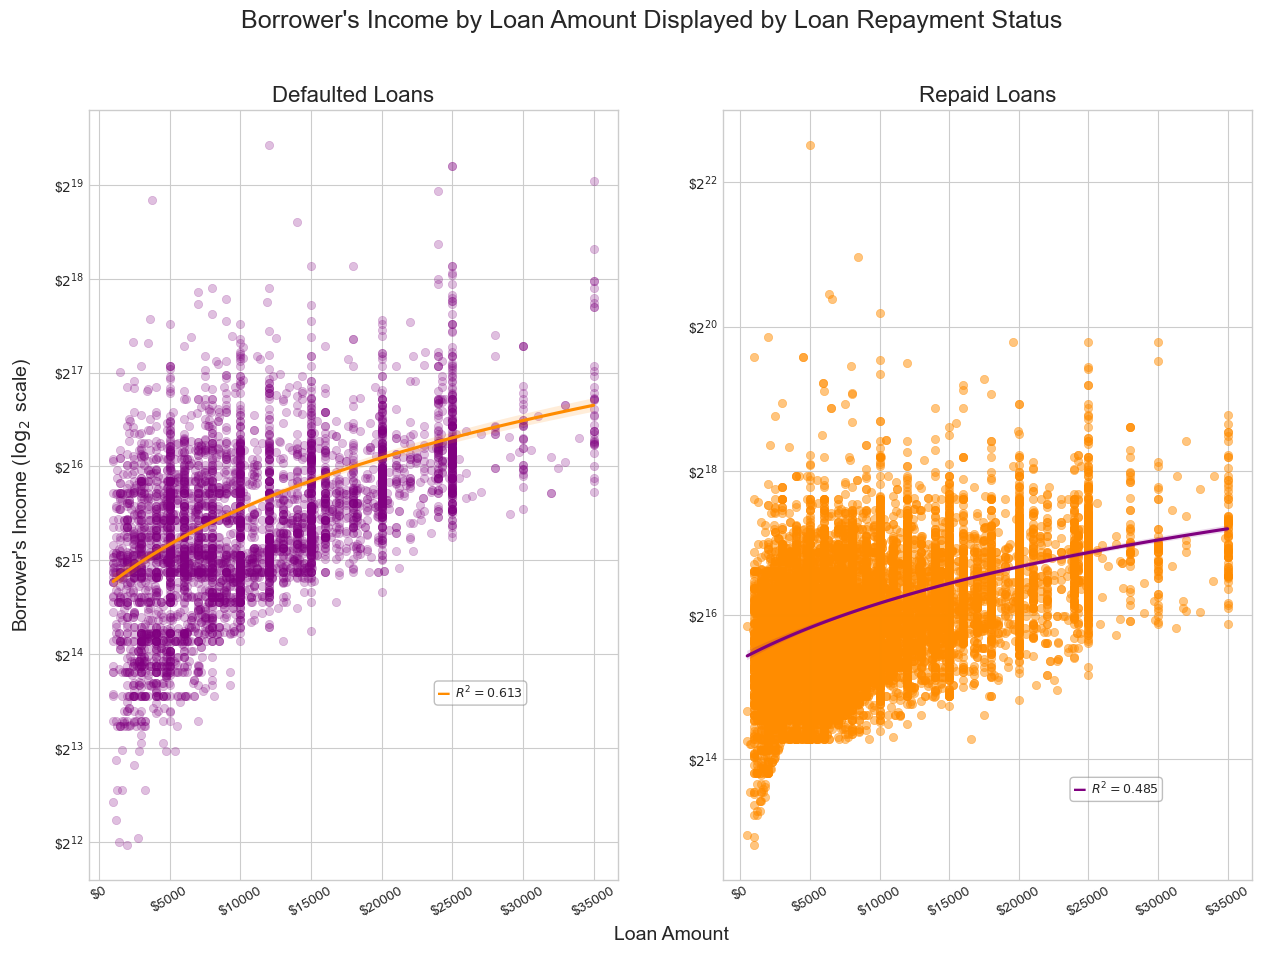

In [253]:
# Plotting
fig, ax = plt.subplots(1, 2, figsize = (15, 10))
plt.style.use('seaborn-v0_8-whitegrid')

# Scatterplot and regression line for borrower income by loan amount of defaulted loans
ax[0] = sns.scatterplot(data = default, x = 'loan_amnt', y = 'person_income', color = 'purple', edgecolor = 'purple', alpha = 0.25, ax = ax[0])
sns.regplot(data = default, x = 'loan_amnt', y = 'person_income', scatter = False, line_kws={'color': 'darkorange'}, ax = ax[0])
ax[0].set_yscale('log', base = 2)
ax[0].set_xlabel('')
ax[0].set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])
ax[0].set_xticklabels(['$0', '$5000', '$10000', '$15000', '$20000', '$25000', '$30000', '$35000'], rotation=30)
ax[0].set_ylabel(f'Borrower\'s Income ($\log_2$ scale)', fontsize = 14, labelpad = 15)
ax[0].set_yticks([2**12, 2**13, 2**14, 2**15, 2**16, 2**17, 2**18, 2**19])
ax[0].set_yticklabels([f'\$$2^{{12}}$', f'\$$2^{{13}}$', f'\$$2^{{14}}$', f'\$$2^{{15}}$', f'\$$2^{{16}}$', f'\$$2^{{17}}$', f'\$$2^{{18}}$', f'\$$2^{{19}}$'])
ax[0].set_title('Defaulted Loans', fontsize = 16)
ax[0].text(27000, 12288, f'     $R^2 = {rs1:.3f}$', ha = 'center', va = 'center', fontsize = 9, 
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'gray', boxstyle = 'round,pad=0.3'))
ax[0].text(24000, 12288, '\u2013', color='darkorange', ha='left', va='center', fontsize=15, fontweight='bold')

# Scatterplot and regression line for borrower income by loan amount of repaid loans
ax[1] = sns.scatterplot(data = repaid, x = 'loan_amnt', y = 'person_income', color = 'darkorange', edgecolor = 'darkorange', alpha = 0.5, ax = ax[1])
sns.regplot(data = repaid, x = 'loan_amnt', y = 'person_income', scatter = False, line_kws={'color': 'purple'}, ax = ax[1])
ax[1].set_yscale('log', base = 2)
ax[1].set_xlabel('')
ax[1].set_xticks([0, 5000, 10000, 15000, 20000, 25000, 30000, 35000])
ax[1].set_xticklabels(['$0', '$5000', '$10000', '$15000', '$20000', '$25000', '$30000', '$35000'], rotation=30)
ax[1].set_ylabel('')
ax[1].set_yticks([2**14, 2**16, 2**18, 2**20, 2**22])
ax[1].set_yticklabels([f'\$$2^{{14}}$', f'\$$2^{{16}}$', f'\$$2^{{18}}$', f'\$$2^{{20}}$', f'\$$2^{{22}}$'])
ax[1].set_title('Repaid Loans', fontsize = 16)
ax[1].text(27000, 12288, f'     $R^2 = {rs2:.3f}$', ha = 'center', va = 'center', fontsize = 9, 
        bbox = dict(facecolor = 'white', alpha = 0.5, edgecolor = 'gray', boxstyle = 'round,pad=0.3'))
ax[1].text(24000, 12288, '\u2013', color='purple', ha='left', va='center', fontsize=15, fontweight='bold')

fig.suptitle('Borrower\'s Income by Loan Amount Displayed by Loan Repayment Status', fontsize = 18)
fig.text(0.475, 0.05, 'Loan Amount', fontsize = 14)

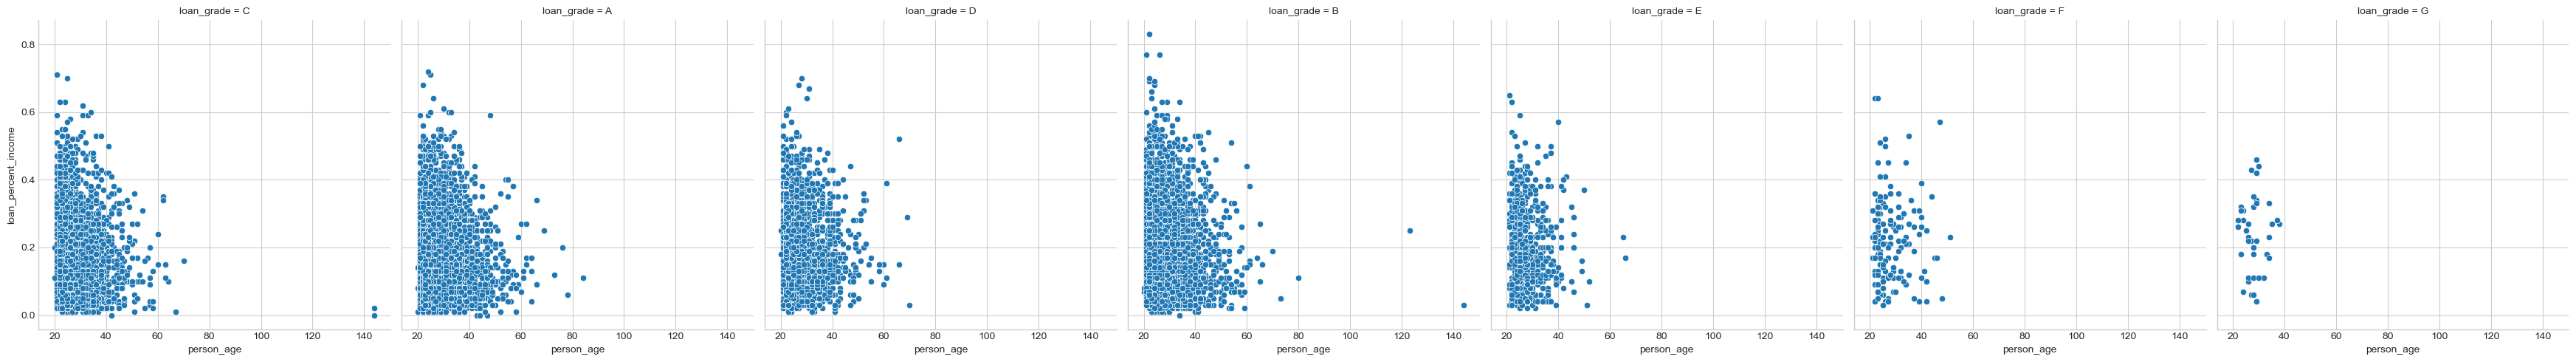

In [263]:
# Additional figure

# Creating subplots of loan-percent-income by person age (for each loan grade)
# fig, ax = plt.subplots(1, 1, figsize = (3, 3))
sns.relplot(train_viz, x = 'person_age', y = 'loan_percent_income', col = 'loan_grade')


plt.show()


*Code Description*

Analysis of the above figures.

### Table of General Summary Statistics

In [255]:
# Summary Statistics

# Helper method to calculate coefficient of variation (%)
def cv(col):
    return (col.std() / col.mean()) * 100


*In creating the table above, I looked up how to calculate the CV for each of the columns to more easily interpret the STD and created the helper method*

Analysis of the summary statistics table.

# Model Construction
## Feature Selection


*Code Description*

Analysis of feature selection.

## Creating a Scoring Function



*Code Description*

Analysis of creating scoring function.

## Choosing a Threshold

*Code Description*

Analysis of choosing a threshold.

# Model Evaluation
## Perspective of the Bank


*Code Description*

Analysis of model evaluation from the perspective of the bank.

## Perspective of the Borrower

*Code Description*

Analysis of model evaluation from the perspective of the borrower.

# Discussion


*During the implementation process of this blog post, I collaborated with __________*